In [42]:
import os
import shutil
import scipy
from scipy import stats
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [44]:
scipy.__version__

'1.3.1'

In [45]:
use_maskrcnn_nucleus_weights = False
use_150epoch_model_weights = False
use_new_trained_weights = True
weights_path='/logs/nissl20230514T1018/mask_rcnn_nissl_1110.h5'
rpn_infer_threshold = 0.9                     #can take 0-1
epoch_number_for_mytrained_model_weights = 150 #can take values from 0001 to 0150

In [46]:
imgdir='/data/nissl_fetal/FB10/train/stage1_train/images'
maskdir='/data/nissl_fetal/FB10/train/stage1_train/masks'
# outdir='/data/nissl_fetal/FB10/inference_out_'+str(epoch_number_for_mytrained_model_weights)+'_rpn'+str(rpn_infer_threshold)

In [47]:
# outdir

'/data/nissl_fetal/FB10/inference_out_150_rpn0.9'

In [48]:
# if not os.path.exists(outdir):
#     os.mkdir(outdir)

In [49]:
A=os.listdir(imgdir)
A.sort()
image_list=A[:12]

mask_list=[]
for i in image_list:
    mask_list.append(i.split('.')[0]+'_annotated.png')

In [50]:
def add_masks_to_dict(image_id,mask,out_mk=True):
    #mask has the shape of (ht,wd,instances) i.e. before combining the instances
    if out_mk:
        output_result[str(image_id)]=mask
    else:
        gt_dict[str(image_id)]=mask
    

In [51]:
from skimage.segmentation import (
    watershed, relabel_sequential, 
    find_boundaries
)
from skimage import measure
import scipy
from skimage.feature import peak_local_max
def label_watershed(fgmask):
    
    distance = scipy.ndimage.distance_transform_edt(fgmask)
    coords = peak_local_max(distance, min_distance=11, footprint=np.ones((7, 7)))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = scipy.ndimage.label(mask)
    return watershed(-distance, markers, mask=fgmask)

def load_mask(image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        colors = [(0,0,255),(0,255,0),(148,0,211),(75,0,130),(255,255,0),(255,127,0),(255,0,0)]
        big_o={}
        cell_masks = []
        import skimage.io
        m = skimage.io.imread(os.path.join(maskdir, "%s_annotated.png"%str(image_id))).astype(np.uint8)

        for ii,clr in enumerate(colors):
            mask = (m[...,0]==clr[0]) & (m[...,1]==clr[1]) & (m[...,2]==clr[2])
            msk_lbl = measure.label(mask)
            props = measure.regionprops_table(msk_lbl,m[...,0],properties=('label','area','bbox_area'))
            big_o[ii] = props['label'][np.where(props['area']>100)]


            for jj in range(1,msk_lbl.max()+1):
                if jj not in big_o[ii]:
                    cell_masks.append(msk_lbl==jj)

                else:         
                    newlbl = label_watershed(msk_lbl==jj)
                    for ll in range(1,newlbl.max()+1):
                        cell_masks.append(newlbl==ll) 

        mask = np.dstack(cell_masks)
        
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

In [52]:
import sys
sys.path.append('../..')
from mrcnn.utils import extract_bboxes,compute_overlaps,compute_overlaps_masks
def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    print(iou_threshold)
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
#     # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
#     pred_scores = pred_scores[:pred_boxes.shape[0]]
#     # Sort predictions by score from high to low
#     indices = np.argsort(pred_scores)[::-1]
#     pred_boxes = pred_boxes[indices]
#     pred_class_ids = pred_class_ids[indices]
#     pred_scores = pred_scores[indices]
#     pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
#     print(pred_match.shape)
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids == gt_class_ids:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
#                 print(pred_match[i])
                break

    return gt_match, pred_match, overlaps


In [53]:
def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps



# Running Inference 

In [54]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.intra_op_parallelism_threads=1
config.inter_op_parallelism_threads=1
set_session(tf.Session(config=config))

In [55]:
import sys
sys.path.append('../..')
from mrcnn.config import Config
import numpy as np
from mrcnn import model as modellib

In [56]:
class NucleusConfig(Config):
    """Configuration for training on the nissl segmentation dataset. while using command "train"
    """
    # Give the configuration a recognizable name
    NAME = "nissl"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1 # since multiprocessing doesn't work

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cell

    # Number of training and validation steps per epoch
    # 238 is the size of train set
    STEPS_PER_EPOCH = 218 // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = max(1, 20 // (IMAGES_PER_GPU * GPU_COUNT))

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nissl and BG
    DETECTION_MIN_CONFIDENCE = 0.4 # 0.6

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (4,8,16,64)#(16, 32, 64, 128, 256)#(4,8,16,64) #(16, 32, 64, 128, 256)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2, 4]

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9 #0.9

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # setting means for R and G to 0 since cells are mostly blue
    MEAN_PIXEL = np.array([0, 0, 117]) #np.array([10, 50, 250])#np.array([0, 0, 110])#np.array([0, 0, 103.9])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (28,28)#(56, 56)  # (height, width) of the mini-mask  suggestion(28,28)
    IMAGE_CHANNEL_COUNT = 3

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128 #2000 #218 #128#710

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 4000 #400

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 4000 #800
# In[5]:
class NucleusInferenceConfig(NucleusConfig):
    """Test-time configurations. while using command "test" or "detect"
    """
    # Set batch size to 1 to run one image at a time
    MEAN_PIXEL=np.array([0, 0, 117])
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7 #0.9
    USE_MINI_MASK = False


In [57]:
def combine_out_array(out):
    if out.shape[-1]>0:
        out_combined = out[...,0].astype(np.uint16)
        for x in range(1,out.shape[-1]):
            out_combined += out[...,x].astype(np.uint16)*(x+1) 
        return out_combined
    else: return np.zeros(out.shape[:-1],out.dtype)

In [58]:
config = NucleusInferenceConfig()
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='/logs')

In [59]:
if use_maskrcnn_nucleus_weights:
    model.load_weights('../../mask_rcnn_nucleus_NISSL.h5', by_name=True) 
if use_150epoch_model_weights:
    model.load_weights('/workspace/logs/nissl20230509T1022/mask_rcnn_nissl_0'+str(epoch_number_for_mytrained_model_weights)+'.h5',by_name=True)
if use_new_trained_weights:
    model.load_weights(weights_path,by_name=True)
    print('using new trained weights epochs')

Re-starting from epoch 1110
using new trained weights epochs


In [60]:
image_list

['14728.jpg',
 '14729.jpg',
 '14730.jpg',
 '14731.jpg',
 '14732.jpg',
 '14733.jpg',
 '14880.jpg',
 '14881.jpg',
 '14882.jpg',
 '14883.jpg',
 '14884.jpg',
 '14885.jpg']

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


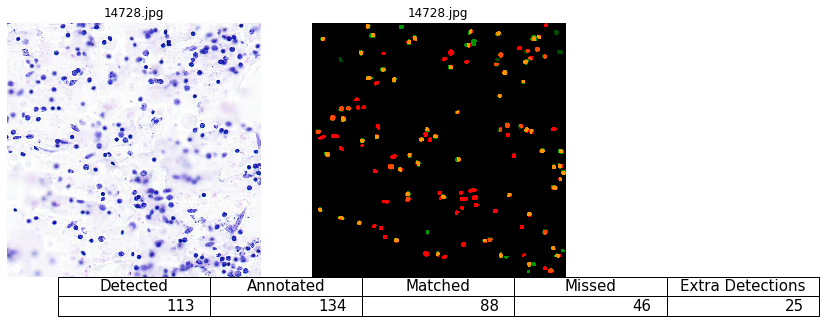

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


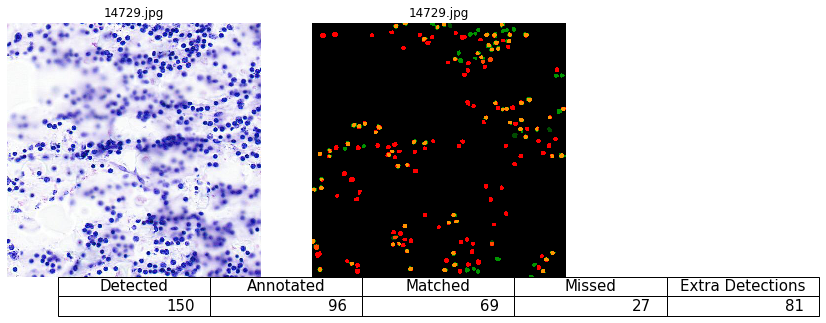

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


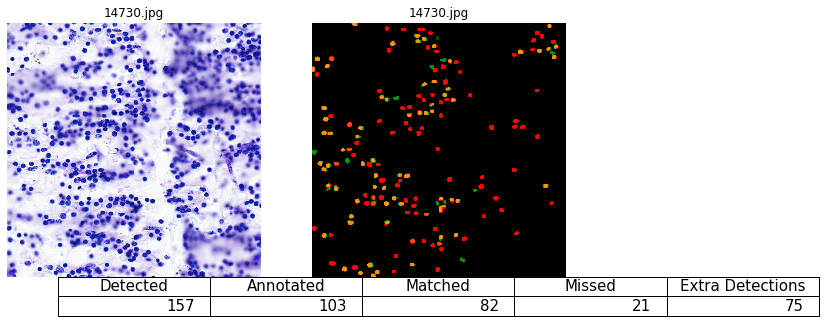

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


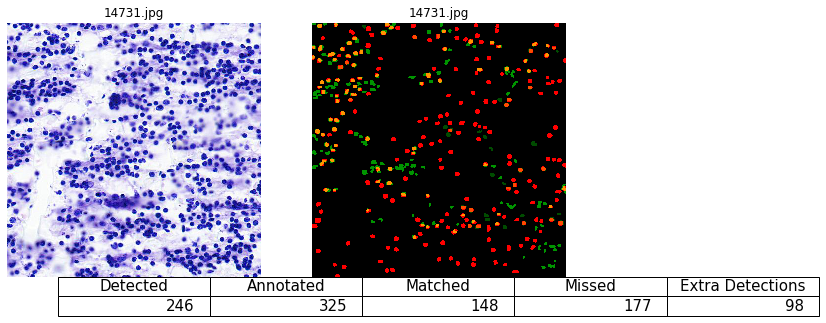

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


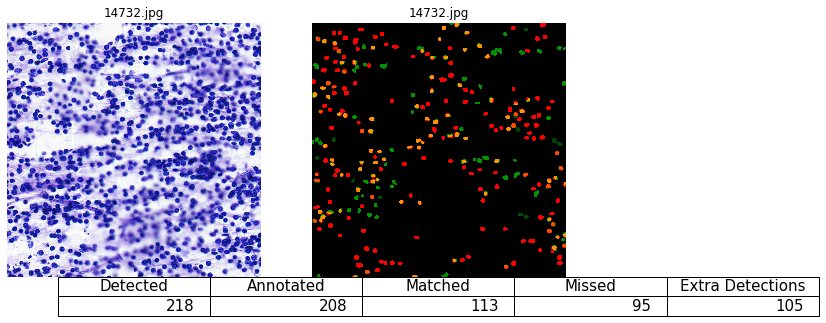

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


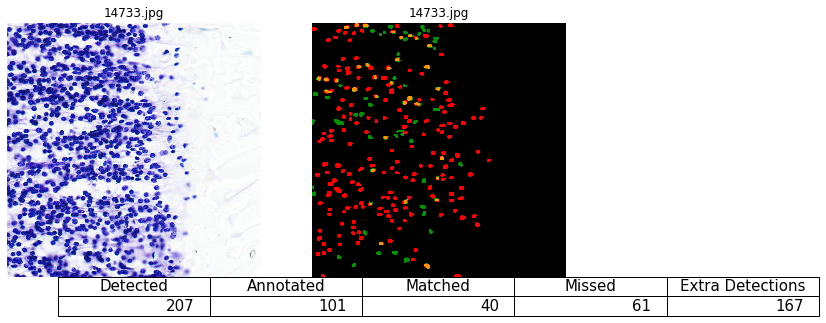

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -39.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


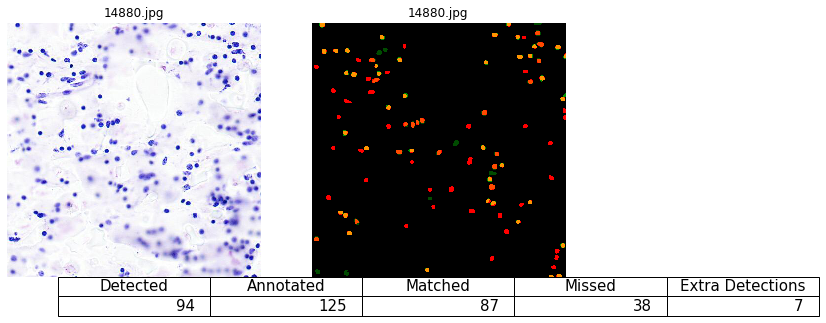

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


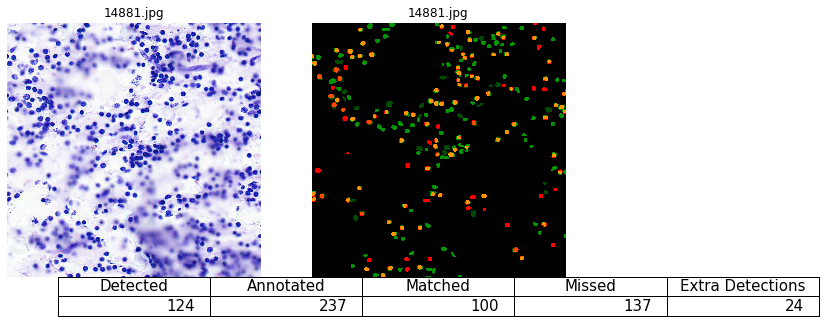

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


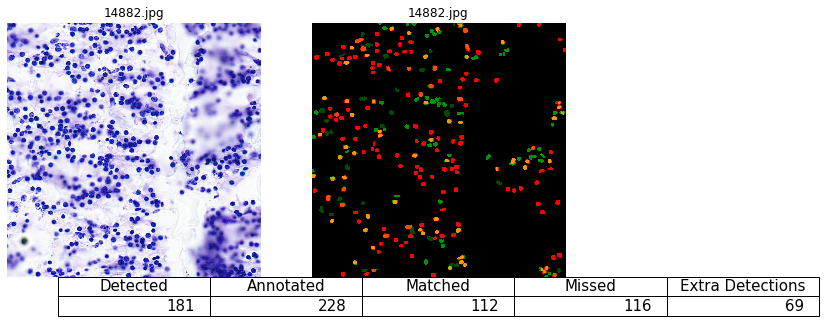

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


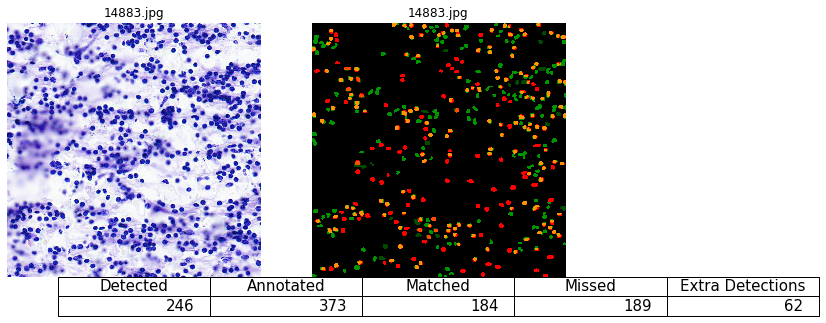

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


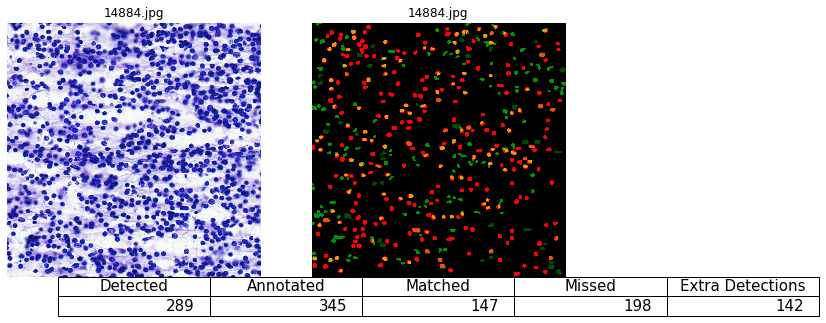

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87040, 4)         min:   -0.12524  max:    1.06262  float32
0.01


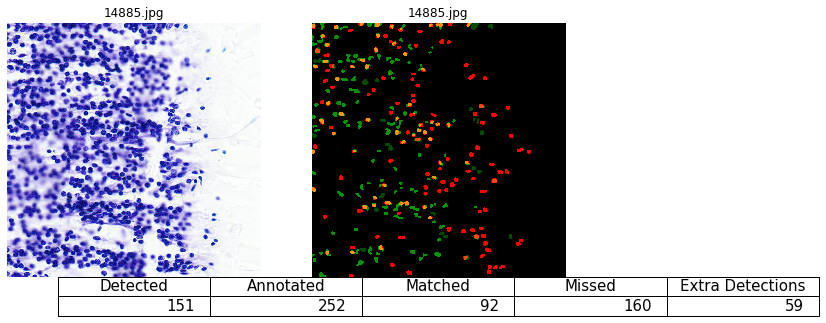

In [61]:
output_result={}
gt_dict = {}
gt_bboxes={}
out_bboxes={}
matched = []

for i,imgfile in enumerate(image_list):
    img_ = imread(os.path.join(imgdir,imgfile))
    image_id=imgfile.split('.')[0]
    gt_mask,_=load_mask(str(image_id))
    add_masks_to_dict(str(image_id),gt_mask,False)
    
    r = model.detect([img_],verbose=1)
    out = r[0]['masks']
    add_masks_to_dict(str(image_id),out,True)
#     print(out.shape[-1])
    
    gt_bboxes[str(image_id)]=extract_bboxes(gt_mask)
    out_bboxes[str(image_id)]=extract_bboxes(out)
    gt_match,pred_match,overlap_mat=compute_matches(gt_bboxes[str(image_id)],1,gt_mask,out_bboxes[str(image_id)],1,1,out,iou_threshold=0.01)
#     gt_match.shape,pred_match.shape             #Matches 
#     np.sum(gt_match==-1),np.sum(pred_match==-1) #Not Matched
    matched_cell_count = pred_match.shape[0]-np.sum(pred_match==-1) #Matched
    unmatched_cell_count =  np.sum(gt_match==-1)                #Missed
    extra_detection_count = np.sum(pred_match==-1)              #Extra Detection
    matched.append(matched_cell_count)
#     print(gt_match.shape,pred_match.shape,np.sum(gt_match==-1),np.sum(pred_match==-1))
    
    combined_out = combine_out_array(out)
    annot = imread(os.path.join(maskdir,mask_list[i]))

    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,1)
    plt.title(imgfile)
    plt.axis('off')
    plt.imshow(img_)
    plt.subplot(1,2,2)
    plt.axis('off')
    tmp = np.dstack([(combined_out>0).astype(np.uint8)*255,annot[...,0],np.zeros_like(annot[...,0])])
#     imsave(os.path.join(outdir,imgfile),tmp)
    plt.title(imgfile)
    plt.imshow(tmp)
    
    
    columns = ('Detected', 'Annotated', 'Matched','Missed','Extra Detections')
    cell_text = [[pred_match.shape[0],gt_mask.shape[-1],matched_cell_count,unmatched_cell_count,extra_detection_count]] 
    the_table=plt.table(cellText=cell_text,
                      colLabels=columns,
                      loc='bottom')
    the_table.set_fontsize(15)
    the_table.scale(3, 3.5)
    plt.show()
#     break

In [62]:
matched#0,0,117 [88, 69, 82, 148, 113, 40, 87, 100, 112, 184, 147, 92]

[88, 69, 82, 148, 113, 40, 87, 100, 112, 184, 147, 92]

In [63]:
# np.sum(np.array([88, 69, 82, 148, 113, 40, 87, 100, 112, 184, 147, 92])-np.array([87, 69, 81, 148, 114, 40, 90, 101, 113, 183, 150, 91]))

In [64]:
# gt_dict

In [65]:
# output_result

In [66]:
# gt_bboxes

In [67]:
# out_bboxes

In [68]:
mAP_list=[]
precision_list=[]
recall_list=[]

for image_id in out_bboxes.keys():    
    out_mask=output_result[image_id]
    out_bbox=out_bboxes[image_id]
    gt_mask=gt_dict[image_id]
    gt_bbox=gt_bboxes[image_id]
    
#     print(out_mask.shape,gt_mask.shape,gt_bbox.shape,out_bbox.shape)
    mAP, precisions, recalls,overlaps_=compute_ap(gt_bbox, 1, gt_mask,out_bbox, 1, 1, out_mask, iou_threshold=0.01)
   
    mAP_list.append(mAP)
    
    precision=[x for x in precisions if x!=1.0]
    precision.sort()
    precision_list.append(precision[-1])
    
    recall=[x for x in recalls if x!=1.0]
    recall.sort()
    recall_list.append(recall[-1])

0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01


In [69]:
mAP_list

[0.6277770016639979,
 0.4572736301229354,
 0.6509006803386951,
 0.2981755680609524,
 0.3979800140202921,
 0.10723192370527392,
 0.6757145822034356,
 0.3626701088897458,
 0.4020568992456856,
 0.4028413235569326,
 0.2827432723159322,
 0.2557847972905838]

In [70]:
precision_list

[0.9807692307692307,
 0.7368421052631579,
 0.9411764705882353,
 0.8,
 0.9285714285714286,
 0.6666666666666666,
 0.9782608695652174,
 0.9166666666666666,
 0.9523809523809523,
 0.95,
 0.9230769230769231,
 0.9090909090909091]

In [71]:
recall_list

[0.6567164063453674,
 0.71875,
 0.7961165308952332,
 0.45538461208343506,
 0.5432692170143127,
 0.39603960514068604,
 0.6959999799728394,
 0.4219409227371216,
 0.4912280738353729,
 0.4932975769042969,
 0.426086962223053,
 0.3650793731212616]